In [1]:

suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))

#for datavisualization
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(zoo))   
suppressMessages(library(forecast)) 

suppressMessages(library(gridExtra))

suppressMessages(library(fable))
suppressMessages(library(fabletools)) ## for add_model function
suppressMessages(library(feasts))
suppressMessages(library(lubridate))

suppressMessages(library(Rmisc))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(imputeTS))
suppressMessages(library(prophet))
options(warn = -1)


Data Load and Performing initial transformation

In [2]:
df <- read.csv('./data/data.csv')
df %>% distinct() %>% dim() #Checking for duplicates#

### Extract county, state, and create date variable
# The `county_name` contains the `county` and `state`. Use `regex` to extract those into separate fields. Convert the `month_date_yyyymm` from an integer to a `monthly date`.

df <-  df %>% 
mutate(county = str_extract(county_name, '^(.*)?, ([a-z]{2})$', group=1)) %>%
mutate(state = str_extract(county_name, '^(.*)?, ([a-z]{2})$', group=2)) %>%
mutate(month_date = tsibble::yearmonth(as.character(month_date_yyyymm), '%Y%m'))

df$county_name <- NULL
df$month_date_yyyymm <- NULL

df %>% head()
colnames(df)
dim(df)

[1] 288385     10

,median_listing_price,active_listing_count,new_listing_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,average_listing_price,total_listing_count,county,state,month_date
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<mth>
1,425000,12,0,1,289,3024,444336,12,hartley,tx,2024 Mar
2,309900,21,8,13,136,2016,397205,35,rock,mn,2024 Mar
3,199000,165,56,59,127,1633,306719,222,carter,ok,2024 Mar
4,169000,48,12,25,89,1898,187270,71,mckean,pa,2024 Mar
5,248950,236,128,67,124,1894,296370,303,etowah,al,2024 Mar
6,679450,135,76,80,227,2802,814852,211,dawson,ga,2024 Mar


[1] "median_listing_price"                
 [2] "active_listing_count"                
 [3] "new_listing_count"                   
 [4] "pending_listing_count"               
 [5] "median_listing_price_per_square_foot"
 [6] "median_square_feet"                  
 [7] "average_listing_price"               
 [8] "total_listing_count"                 
 [9] "county"                              
[10] "state"                               
[11] "month_date"

[1] 288385     11

In [3]:
print(colSums(is.na(df)))

                median_listing_price                 active_listing_count 
                                  63                                   45 
                   new_listing_count                pending_listing_count 
                                  43                                23871 
median_listing_price_per_square_foot                   median_square_feet 
                                 328                                  325 
               average_listing_price                  total_listing_count 
                                  63                                   43 
                              county                                state 
                                   0                                    0 
                          month_date 
                                   0 


Handling NULL values

In [4]:
library(dplyr)

# Define a function to fill missing values within each state
fill_pending_listing_count <- function(df) {
  df <- df %>%
    group_by(state) %>%
    mutate(pending_listing_count = ifelse(is.na(pending_listing_count), 
                                          median(pending_listing_count, na.rm = TRUE), 
                                          pending_listing_count))
  return(df)
}
df_filled <- fill_pending_listing_count(df)

fill_active_listing_count <- function(df) {
  df <- df %>%
    group_by(state) %>%
    mutate(active_listing_count = ifelse(is.na(active_listing_count), 
                                          median(active_listing_count, na.rm = TRUE), 
                                          active_listing_count))
  return(df)
}

df_filled <- fill_active_listing_count(df_filled)

fill_new_listing_count <- function(df) {
  df <- df %>%
    group_by(state) %>%
    mutate(new_listing_count = ifelse(is.na(new_listing_count), 
                                          median(new_listing_count, na.rm = TRUE), 
                                          new_listing_count))
  return(df)
}

df_filled <- fill_new_listing_count(df_filled)

fill_median_listing_price <- function(df) {
  df <- df %>%
    group_by(state) %>%
    mutate(median_listing_price = ifelse(is.na(median_listing_price), 
                                          mean(median_listing_price, na.rm = TRUE), 
                                          median_listing_price))
  return(df)
}

df_filled <- fill_median_listing_price(df_filled)

# Check the result
# head(df_filled)
print('Has nulls pending_listing_count')
any(is.na(df_filled$pending_listing_count))
print("Has nulls new_listing_count")
any(is.na(df_filled$new_listing_count))
print("Has nulls active_listing_count")
any(is.na(df_filled$active_listing_count))
print('Has nulls median_listing_price')
any(is.na(df_filled$median_listing_price))

df <- df_filled %>% select('state','county','month_date','median_listing_price','active_listing_count','new_listing_count','pending_listing_count')

[1] "Has nulls pending_listing_count"


[1] FALSE

[1] "Has nulls new_listing_count"


[1] FALSE

[1] "Has nulls active_listing_count"


[1] FALSE

[1] "Has nulls median_listing_price"


[1] FALSE

Checking for Duplicates in the dataset

In [5]:
df %>% duplicates() %>% dim()
df %>% dim()

Using `month_date` as index variable.


[1] 288385      7

[1] 288385      7

In [6]:
df_ts <- df %>% as_tsibble(index=month_date, key=c(state,county))
df_ts %>% head()
print('Dimension of data before identifying gaps - ')
df_ts %>% dim()
df_ts <- df_ts %>% fill_gaps()
print('Dimension of data after identifying and filling gaps')
df_ts %>% dim()
any(is.na(df_ts$median_listing_price))

state,county,month_date,median_listing_price,active_listing_count,new_listing_count,pending_listing_count
<chr>,<chr>,<mth>,<dbl>,<dbl>,<dbl>,<dbl>
ak,aleutians east,2016 Jul,485000,3,0,24
ak,aleutians east,2016 Aug,342250,4,0,24
ak,aleutians east,2016 Sep,342250,4,0,24
ak,aleutians east,2016 Oct,199500,4,0,24
ak,aleutians east,2016 Nov,342250,4,0,24
ak,aleutians east,2016 Dec,342250,4,0,24


[1] "Dimension of data before identifying gaps - "


[1] 288385      7

[1] "Dimension of data after identifying and filling gaps"


[1] 290690      7

[1] TRUE

In [7]:
colSums(is.na(df_ts))


state                county            month_date 
                    0                     0                     0 
 median_listing_price  active_listing_count     new_listing_count 
                 2305                  2305                  2305 
pending_listing_count 
                 2305

Handling Gaps using **linear interpolation**

In [8]:
df_ts %>% head(1) %>% print()
df_ts_interpolated <- df_ts %>%
  mutate(
    median_listing_price = na.approx(median_listing_price),
    active_listing_count = na.approx(active_listing_count),
    new_listing_count = na.approx(new_listing_count),
    pending_listing_count = na.approx(pending_listing_count)
  )
colSums(is.na(df_ts_interpolated))

# A tsibble: 1 x 7 [1M]
# Key:       state, county [1]
# Groups:    state [1]
  state county         month_date median_listing_price active_listing_count
  <chr> <chr>               <mth>                <dbl>                <dbl>
1 ak    aleutians east   2016 Jul               485000                    3
# ℹ 2 more variables: new_listing_count <dbl>, pending_listing_count <dbl>


state                county            month_date 
                    0                     0                     0 
 median_listing_price  active_listing_count     new_listing_count 
                    0                     0                     0 
pending_listing_count 
                    0

In [9]:
write.csv(df_ts_interpolated %>% as.data.frame(), './data/df_after_filling_nulls.csv',row.names=FALSE)

In [10]:
df = read.csv('./data/df_after_filling_nulls.csv')
df %>% dim()
colSums(is.na(df))
df <- df %>% mutate(month_date = tsibble::yearmonth(as.character(month_date), '%Y%m'))
df %>% head(2)
df_ts <- df %>% as_tsibble(index=month_date, key = c(state,county))

[1] 290690      7

state                county            month_date 
                    0                     0                     0 
 median_listing_price  active_listing_count     new_listing_count 
                    0                     0                     0 
pending_listing_count 
                    0

,state,county,month_date,median_listing_price,active_listing_count,new_listing_count,pending_listing_count
,<chr>,<chr>,<mth>,<dbl>,<dbl>,<dbl>,<dbl>
1,ak,aleutians east,2016 Jul,485000,3,0,24
2,ak,aleutians east,2016 Aug,342250,4,0,24


Visualising the charts

Saving 6.67 x 6.67 in image


[1] "Count of NULLS in each columns chosen ... "
 median_listing_price  active_listing_count     new_listing_count 
                    0                     0                     0 
pending_listing_count            month_date                 state 
                    0                     0                     0 
               county 
                    0 


[1] 290690      7

[1] "Post handling nulls"


state,county,month_date,median_listing_price,active_listing_count,new_listing_count,pending_listing_count,median_listing_price_nc,active_listing_count_nc,new_listing_count_nc,pending_listing_count_nc
<chr>,<chr>,<mth>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ak,aleutians east,2016 Jul,485000,3,0,24,485000,3,0,24
ak,aleutians east,2016 Aug,342250,4,0,24,342250,4,0,24


[1] "Post handling NULLS .... "


Saving 6.67 x 6.67 in image


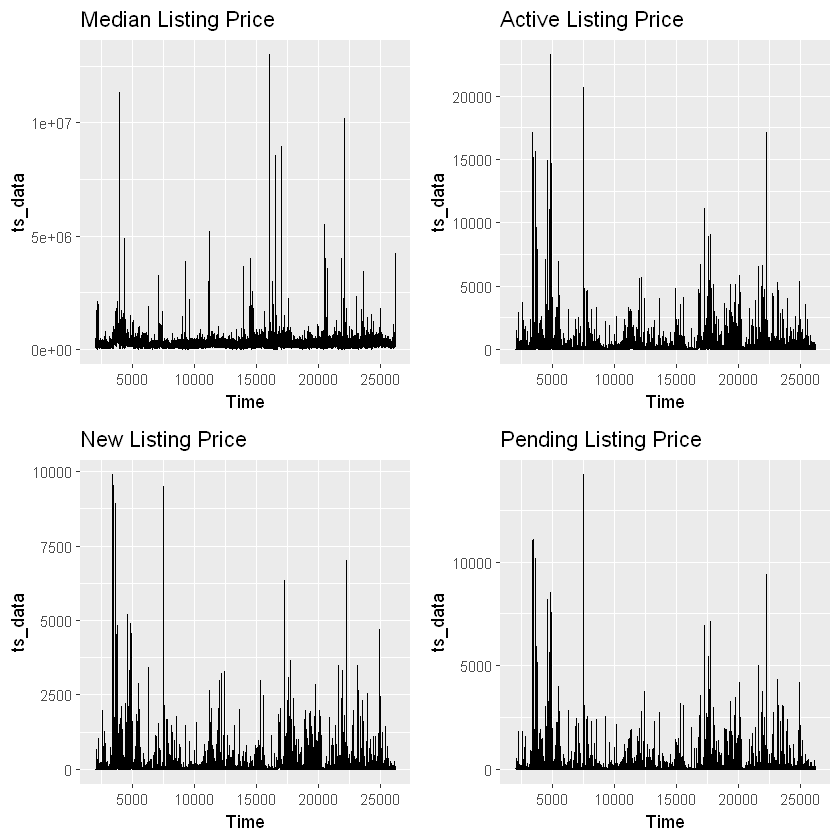

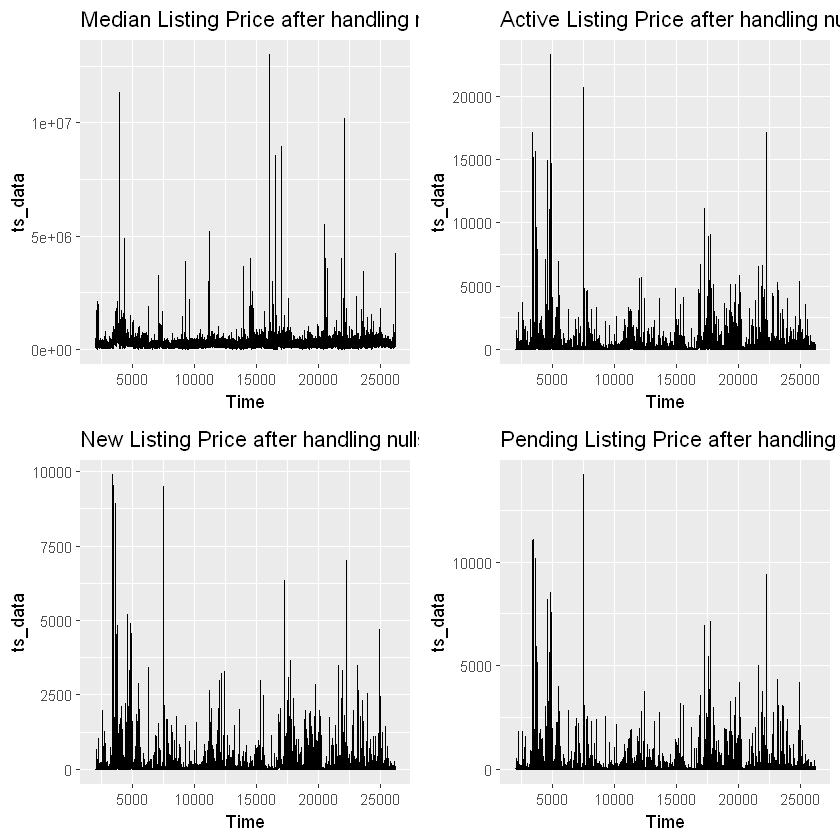

In [11]:
ts_data <- ts(df_ts$median_listing_price, frequency = 12, start = c(year(min(df$month_date)), month(min(df$month_date))))
p1 <- autoplot(ts_data) + labs(title = "Median Listing Price")
ts_data <- ts(df_ts$active_listing_count, frequency = 12, start = c(year(min(df$month_date)), month(min(df$month_date))))
p2 <- autoplot(ts_data) + labs(title = "Active Listing Price")
ts_data <- ts(df_ts$new_listing_count, frequency = 12, start = c(year(min(df$month_date)), month(min(df$month_date))))
p3 <- autoplot(ts_data) + labs(title = "New Listing Price")
ts_data <- ts(df_ts$pending_listing_count, frequency = 12, start = c(year(min(df$month_date)), month(min(df$month_date))))
p4 <- autoplot(ts_data) + labs(title = "Pending Listing Price")
ggsave('./plots/Initial_data.png',grid.arrange(p1,p2,p3,p4,ncol = 2))


print('Count of NULLS in each columns chosen ... ')
print(colSums(is.na(df_ts %>% select(median_listing_price,active_listing_count,new_listing_count,pending_listing_count))))
dim(df_ts)


# Replace NA with median for each specified column
df_ts$median_listing_price_nc <- df_ts$median_listing_price
df_ts$active_listing_count_nc<- df_ts$active_listing_count
df_ts$new_listing_count_nc <- df_ts$new_listing_count
df_ts$pending_listing_count_nc <- df_ts$pending_listing_count

# Replace NA with median for each specified column
df_ts$median_listing_price_nc[is.na(df_ts$median_listing_price_nc)] <- mean(df_ts$median_listing_price, na.rm = TRUE)
df_ts$active_listing_count_nc[is.na(df_ts$active_listing_count_nc)] <- median(df_ts$active_listing_count, na.rm = TRUE)
df_ts$new_listing_count_nc[is.na(df_ts$new_listing_count_nc)] <- median(df_ts$new_listing_count, na.rm = TRUE)
df_ts$pending_listing_count_nc[is.na(df_ts$pending_listing_count_nc)] <- median(df_ts$pending_listing_count, na.rm = TRUE)
print('Post handling nulls')
df_ts %>% head(2)

print('Post handling NULLS .... ')
ts_data <- ts(df_ts$median_listing_price_nc, frequency = 12, start = c(year(min(df_ts$month_date)), month(min(df_ts$month_date))))
p1 <- autoplot(ts_data) + labs(title = "Median Listing Price after handling nulls")
ts_data <- ts(df_ts$active_listing_count_nc, frequency = 12, start = c(year(min(df_ts$month_date)), month(min(df_ts$month_date))))
p2 <- autoplot(ts_data) + labs(title = "Active Listing Price after handling nulls")
ts_data <- ts(df_ts$new_listing_count_nc, frequency = 12, start = c(year(min(df_ts$month_date)), month(min(df_ts$month_date))))
p3 <- autoplot(ts_data) + labs(title = "New Listing Price after handling nulls")
ts_data <- ts(df_ts$pending_listing_count_nc, frequency = 12, start = c(year(min(df_ts$month_date)), month(min(df_ts$month_date))))
p4 <- autoplot(ts_data) + labs(title = "Pending Listing Price after handling nulls")
ggsave('./plots/data_after_filling_missing_values.png',grid.arrange(p1,p2,p3,p4,ncol = 2))


In [12]:
colSums(is.na(df_ts))

state                   county               month_date 
                       0                        0                        0 
    median_listing_price     active_listing_count        new_listing_count 
                       0                        0                        0 
   pending_listing_count  median_listing_price_nc  active_listing_count_nc 
                       0                        0                        0 
    new_listing_count_nc pending_listing_count_nc 
                       0                        0

Checking for outliers at lower hierarchy

In [13]:
# Function to detect outliers using IQR
detect_outliers_IQR <- function(x) {
  iqr <- IQR(x)
  lower_bound <- quantile(x, 0.25) - 1.5 * iqr
  upper_bound <- quantile(x, 0.75) + 1.5 * iqr
  outliers <- x[x < lower_bound | x > upper_bound]
  return(outliers)
}

# Group data by state and year, and then apply outlier detection function
outliers <- lapply(unique(df$state), function(state) {
  lapply(unique(df$year), function(year) {
    subset <- df[df$state == state & df$year == year, relevant_columns]
    outliers <- lapply(subset, detect_outliers_IQR)
    list(state = state, year = year, outliers = outliers)
  })
})

# Print outliers for each state and year
for (state_outliers in outliers) {
  for (year_outliers in state_outliers) {
    state <- year_outliers$state
    year <- year_outliers$year
    cat("Outliers in '", state, "' for year '", year, "':\n")
    for (i in seq_along(relevant_columns)) {
      col <- relevant_columns[i]
      outlier_values <- year_outliers$outliers[[i]]
      num_outliers <- length(outlier_values)
      cat("  - ", col, ": Number of outliers: ", num_outliers, "\n")
      if (num_outliers > 0) {
        cat("    Outlier values: ", toString(outlier_values), "\n")
      }
    }
  }
}


In [14]:
write.csv(df_ts,'./data/data_after_filling_nulls.csv',row.names=FALSE)

In [19]:
df = read.csv('./data/data_after_filling_nulls.csv')
df %>% dim()
colSums(is.na(df))
df <- df %>% mutate(month_date = tsibble::yearmonth(as.character(month_date), '%Y%m'))

df <- df %>% 
        select(-median_listing_price_nc,
                -active_listing_count_nc,
                -new_listing_count_nc,
                -pending_listing_count_nc
            )

[1] 290690     11

state                   county               month_date 
                       0                        0                        0 
    median_listing_price     active_listing_count        new_listing_count 
                       0                        0                        0 
   pending_listing_count  median_listing_price_nc  active_listing_count_nc 
                       0                        0                        0 
    new_listing_count_nc pending_listing_count_nc 
                       0                        0

Data Aggregation natital and State wise

In [18]:
result <- aggregate(
    cbind(
      median_listing_price, 
      new_listing_count, 
      active_listing_count, 
      pending_listing_count
    ) ~ state + month_date,
    df, 
    FUN = function(x) c(sum = sum(x), mean = mean(x))
  )
result %>% head(2) %>% print()
# print(result %>% head(2))

result$median_listing_price <- result$median_listing_price[, 2]
result$active_listing_count <- result$active_listing_count[, 1] ## getting sum for counts
result$new_listing_count <- result$new_listing_count[, 1]
result$pending_listing_count <- result$pending_listing_count[, 1]

write.csv(result,'./data/state_wise_aggregate.csv',row.names = FALSE)
# df %>% filter(month_date ==yearmonth(as.character('2016 Jul'))) %>% select(active_listing_count) %>% sum()

# sum(df[df['month_date']=='2016 Jul']['active_listing_count'])
result <- aggregate(
    cbind(
      median_listing_price, 
      new_listing_count, 
      active_listing_count, 
      pending_listing_count
    ) ~ month_date,
    df, 
    FUN = function(x) c(sum = sum(x), mean = mean(x))
  )
result %>% head(2)
result$median_listing_price <- result$median_listing_price[, 2]
result$active_listing_count <- result$active_listing_count[, 1] ## getting sum for counts
result$new_listing_count <- result$new_listing_count[, 1]
result$pending_listing_count <- result$pending_listing_count[, 1]
# result %>% head(2)
write.csv(result,'./data/national_aggregate.csv',row.names = FALSE)

  state month_date median_listing_price.sum median_listing_price.mean
1    ak   2016 Jul                6703400.0                  257823.1
2    al   2016 Jul               10948380.0                  163408.7
  new_listing_count.sum new_listing_count.mean active_listing_count.sum
1            1184.00000               45.53846                3795.0000
2            7480.00000              111.64179               30457.0000
  active_listing_count.mean pending_listing_count.sum
1                  145.9615                 555.00000
2                  454.5821                2665.00000
  pending_listing_count.mean
1                   21.34615
2                   39.77612


,month_date,median_listing_price,new_listing_count,active_listing_count,pending_listing_count
,<mth>,"<dbl[,2]>","<dbl[,2]>","<dbl[,2]>","<dbl[,2]>"
1,2016 Jul,"605055310, 196510.3","497388.0, 161.5421","1463458, 475.3030","428460.0, 139.1556"
2,2016 Aug,"593072493, 192368.6","464936.7, 150.8066","1456822, 472.5339","407334.1, 132.1226"


Working on national aggregates

In [23]:
df <- read.csv('./data/national_aggregate.csv')
df %>% dim()
df <- df %>%
    mutate(month_date = tsibble::yearmonth(as.character(month_date), '%Y%m')) 
df_ts <- df %>% as_tsibble(index=month_date)
df_ts %>% has_gaps() %>% filter(.gaps == TRUE) %>% dim()
df %>% head(2)

[1] 93  5

[1] 0 1

,month_date,median_listing_price,new_listing_count,active_listing_count,pending_listing_count
,<mth>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016 Jul,196510.3,497388.0,1463458,428460.0
2,2016 Aug,192368.6,464936.7,1456822,407334.1


Visualizing original data

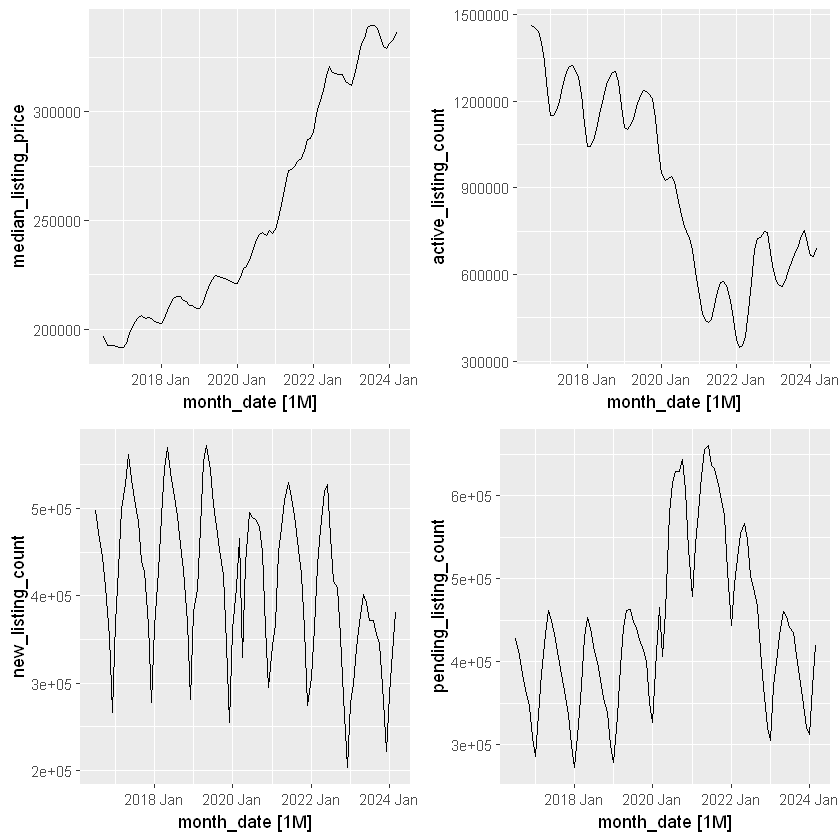

In [24]:
p1 <- df_ts %>% autoplot(median_listing_price)
p2 <- df_ts %>% autoplot(active_listing_count)
p3 <- df_ts %>% autoplot(new_listing_count)
p4 <- df_ts %>% autoplot(pending_listing_count)

grid.arrange(p1,p2,p3,p4,ncol=2)

Splitting train vs test data

In [25]:
df_ts %>% dim()
df_train <- df_ts %>% 
    filter(month_date <=  yearmonth(as.character('2023 Mar'), format = '%Y %m'))
df_test <- df_ts %>% 
    filter(month_date >  yearmonth(as.character('2023 Mar'), format = '%Y %m'))

df_train %>% tail(2)
df_test %>% head(2)

[1] 93  5

month_date,median_listing_price,new_listing_count,active_listing_count,pending_listing_count
<mth>,<dbl>,<dbl>,<dbl>,<dbl>
2023 Feb,318395.3,300078.5,577328.3,371916.4
2023 Mar,324956.6,340008.9,560567.5,399111.3


month_date,median_listing_price,new_listing_count,active_listing_count,pending_listing_count
<mth>,<dbl>,<dbl>,<dbl>,<dbl>
2023 Apr,331608.8,369932.6,558027.8,431913.0
2023 May,333812.7,401928.1,579572.7,460178.3


Visualizing seasonality

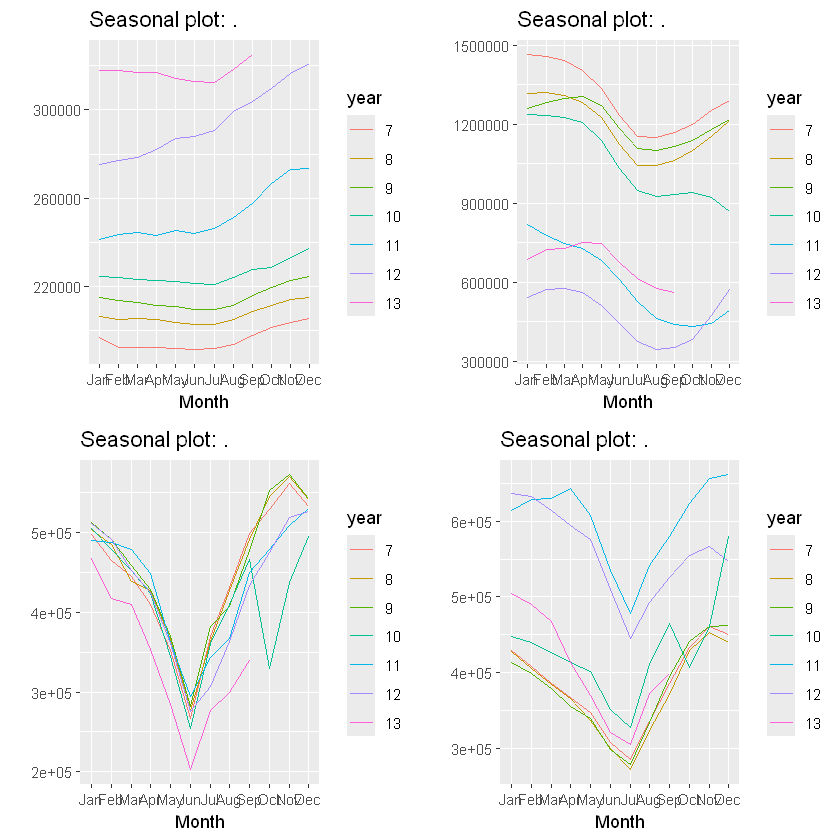

In [26]:
df_train_mlp = ts(
    df_train$median_listing_price,
    start=c(year(df_train$month_date[0]) , month(df_train$month_date[1])),
    frequency = 12
    )
df_train_alc = ts(
    df_train$active_listing_count,
    start=c(year(df_train$month_date[0]) , month(df_train$month_date[1])),
    frequency = 12
    )
df_train_nlc = ts(
    df_train$new_listing_count,
    start=c(year(df_train$month_date[0]) , month(df_train$month_date[1])),
    frequency = 12
    )
df_train_plc = ts(
    df_train$pending_listing_count,
    start=c(year(df_train$month_date[0]) , month(df_train$month_date[1])),
    frequency = 12
    )
p1 <- df_train_mlp %>% ggseasonplot()
p2 <- df_train_alc %>% ggseasonplot()
p3 <- df_train_nlc %>% ggseasonplot()
p4 <- df_train_plc %>% ggseasonplot()
grid.arrange(p1,p2,p3,p4,ncol=2)

Fitting models and performing insample forecast (2023 Apr to 2024 Mar)

[1] "Report for Median Listing Price"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1749.872,1755.305,1781.000,0.005471485
stlm_t,1545.325,1545.636,1552.508,0.898108765
stlm_st,1562.702,1569.066,1596.225,0.903760298


[1] "Report for Active Listing Count"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,2077.373,2082.806,2108.501,0.08318014
stlm_t,1942.970,1943.282,1950.154,0.77669746
stlm_st,1945.888,1952.252,1979.410,0.82356673


[1] "Report for New Listing Count"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1731.889,1737.322,1763.017,0.81218647
stlm_t,1841.555,1841.867,1848.739,0.06899401
stlm_st,1706.931,1713.294,1740.453,0.86535705


[1] "Report for Pending Listing Count"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1873.729,1879.162,1904.857,0.2598862
stlm_t,1854.590,1854.901,1861.773,0.2519835
stlm_st,1836.851,1843.215,1870.373,0.5420211


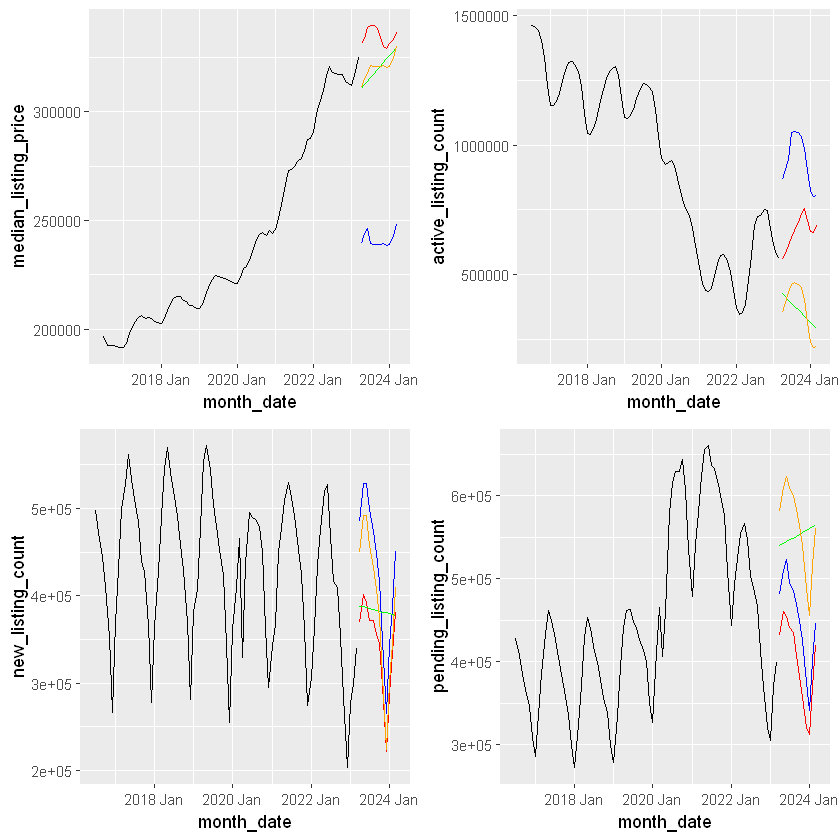

In [27]:
fit_mlp <- df_train %>% 
    model(
        stlm_s = TSLM(median_listing_price ~ season()),
        stlm_t = TSLM(median_listing_price ~ trend()),
        stlm_st = TSLM(median_listing_price ~ season() + trend())
    )
print('Report for Median Listing Price')
fit_mlp %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_mlp <- fit_mlp %>% forecast(h = 12)
# frcst_mlp %>% head(2)

fit_alc <- df_train %>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(active_listing_count ~ trend()),
        stlm_st = TSLM(active_listing_count ~ season() + trend())
    )
print('Report for Active Listing Count')
fit_alc %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_alc <- fit_alc %>% forecast(h = 12)
# frcst_alc %>% head(2)


fit_nlc <- df_train %>% 
    model(
        stlm_s = TSLM(new_listing_count ~ season()),
        stlm_t = TSLM(new_listing_count ~ trend()),
        stlm_st = TSLM(new_listing_count ~ season() + trend())
    )
print('Report for New Listing Count')
fit_nlc %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_nlc <- fit_nlc %>% forecast(h = 12)
# frcst_nlc %>% head(2)

fit_plc <- df_train %>% 
    model(
        stlm_s = TSLM(pending_listing_count ~ season()),
        stlm_t = TSLM(pending_listing_count ~ trend()),
        stlm_st = TSLM(pending_listing_count ~ season() + trend())
    )
print('Report for Pending Listing Count')
fit_plc %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_plc <- fit_plc %>% forecast(h = 12)
# frcst_plc %>% head(2)

p1 <- ggplot(data = df_train, aes(x = month_date)) +
    geom_line(aes(y = median_listing_price))+
    geom_line(data = df_test, aes(y = median_listing_price), color ='red') +
    geom_line(data = frcst_mlp %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
    geom_line(data = frcst_mlp %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
    geom_line(data = frcst_mlp %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
    geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Median Listing Price'),vjust = -1)


p2 <- ggplot(data = df_train, aes(x = month_date)) +
    geom_line(aes(y = active_listing_count))+
    geom_line(data = df_test, aes(y = active_listing_count), color ='red') +
    geom_line(data = frcst_alc %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
    geom_line(data = frcst_alc %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
    geom_line(data = frcst_alc %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange') +
    geom_text(data = NULL,aes(x = Inf, y = Inf,label = 'Active Listing Count'),vjust = -1)


p3 <- ggplot(data = df_train, aes(x = month_date)) +
    geom_line(aes(y = new_listing_count))+
    geom_line(data = df_test, aes(y = new_listing_count), color ='red') +
    geom_line(data = frcst_nlc %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
    geom_line(data = frcst_nlc %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
    geom_line(data = frcst_nlc %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange') +
    geom_text(data = NULL,aes(x = Inf, y = Inf,label = 'new Listing Count'),vjust = -1)

p4 <- ggplot(data = df_train, aes(x = month_date)) +
    geom_line(aes(y = pending_listing_count))+
    geom_line(data = df_test, aes(y = pending_listing_count), color ='red') +
    geom_line(data = frcst_plc %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
    geom_line(data = frcst_plc %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
    geom_line(data = frcst_plc %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange') +
    geom_text(data = NULL,aes(x = Inf, y = Inf,label = 'pending Listing Count'),vjust = -1)

grid.arrange(p1,p2,p3,p4,ncol = 2)

In [28]:
df_test$median_listing_price <- frcst_mlp %>%
    filter(.model == 'stlm_st') %>%
    mutate(median_listing_price_frcst = .mean) %>% as.data.frame() %>%
    select(median_listing_price_frcst) %>% unlist()

df_test$active_listing_count <- frcst_alc %>%
    filter(.model == 'stlm_st') %>%
    mutate(active_listing_count_frcst = .mean) %>% as.data.frame() %>%
    select(active_listing_count_frcst) %>% unlist()

df_test$new_listing_count <- frcst_nlc %>%
    filter(.model == 'stlm_st') %>%
    mutate(new_listing_count_frcst = .mean) %>% as.data.frame() %>%
    select(new_listing_count_frcst) %>% unlist()

df_test$pending_listing_count <- frcst_plc %>%
    filter(.model == 'stlm_st') %>%
    mutate(pending_listing_count_frcst = .mean) %>% as.data.frame() %>%
    select(pending_listing_count_frcst) %>% unlist()
df_test %>% head(2)

month_date,median_listing_price,new_listing_count,active_listing_count,pending_listing_count
<mth>,<dbl>,<dbl>,<dbl>,<dbl>
2023 Apr,311274.2,449580.5,354020.6,581547.7
2023 May,315551.6,492576.0,392582.4,609867.4


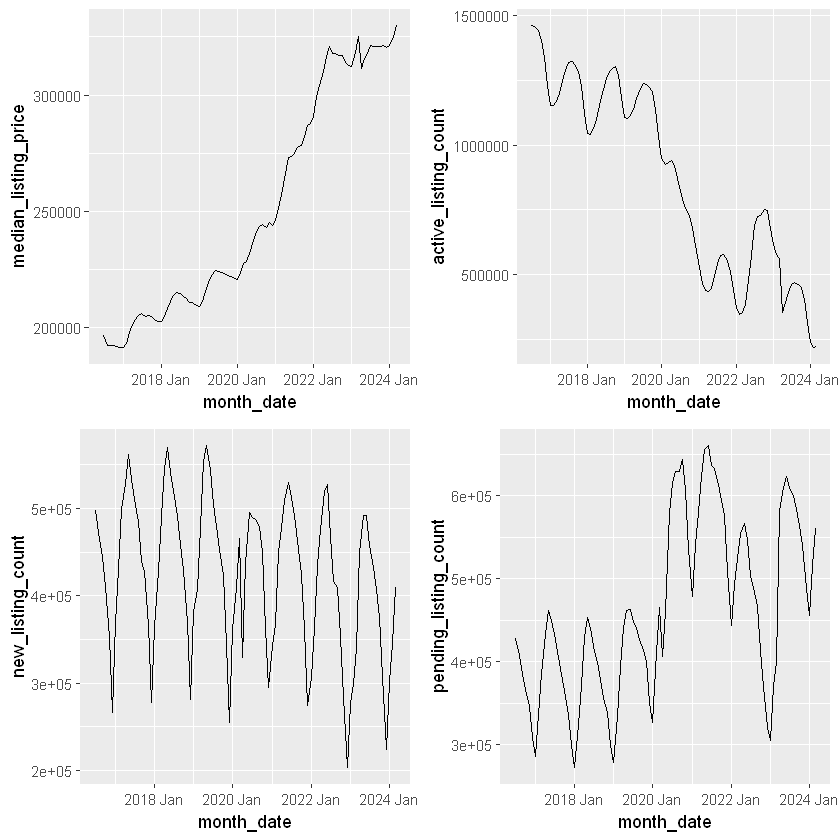

In [29]:
combined_df <- bind_rows(df_train,df_test)
p1 <- ggplot(data = combined_df,aes(x = month_date,y = median_listing_price))+
geom_line()

p2 <- ggplot(data = combined_df,aes(x = month_date,y = active_listing_count))+
geom_line()

p3 <- ggplot(data = combined_df,aes(x = month_date,y = new_listing_count))+
geom_line()

p4 <- ggplot(data = combined_df,aes(x = month_date,y = pending_listing_count))+
geom_line()

grid.arrange(p1,p2,p3,p4,ncol = 2)

In [30]:
df_train <- combined_df

Performing out of sample forecast using train + insample forecasted data

[1] "Median Listing Price"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,2028.064,2032.671,2060.988,0.004290953
stlm_t,1761.281,1761.551,1768.879,0.929903177
stlm_st,1777.218,1782.602,1812.674,0.934327491


[1] "Active Listing Count"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,2400.893,2405.501,2433.817,0.06821617
stlm_t,2219.912,2220.182,2227.510,0.83497063
stlm_st,2217.172,2222.556,2252.628,0.87351870


[1] "New Listing Count"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1984.475,1989.082,2017.398,0.81261364
stlm_t,2111.879,2112.148,2119.477,0.08569621
stlm_st,1942.813,1948.198,1978.270,0.88282197


[1] "Pending Listing Count"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,2151.356,2155.963,2184.280,0.2521218
stlm_t,2120.849,2121.119,2128.447,0.3320157
stlm_st,2091.981,2097.366,2127.437,0.6134370


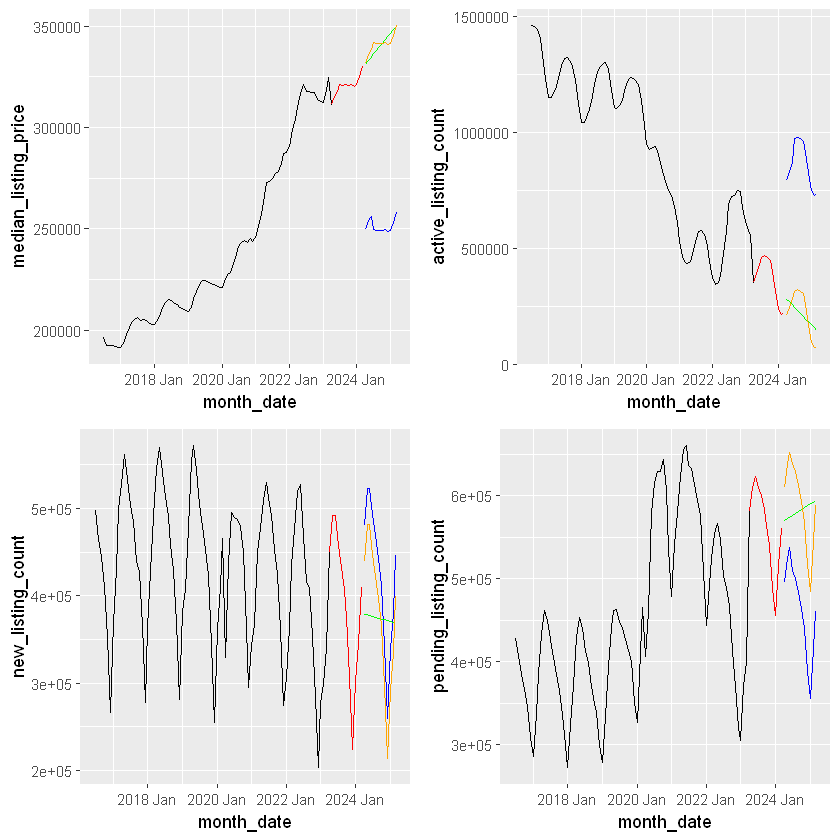

In [31]:
fit_mlp <- df_train %>% 
    model(
        stlm_s = TSLM(median_listing_price ~ season()),
        stlm_t = TSLM(median_listing_price ~ trend()),
        stlm_st = TSLM(median_listing_price ~ season() + trend())
    )

print('Median Listing Price')
fit_mlp %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_mlp <- fit_mlp %>% forecast(h = 12)
# frcst_mlp %>% head(2)

fit_alc <- df_train %>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(active_listing_count ~ trend()),
        stlm_st = TSLM(active_listing_count ~ season() + trend())
    )
print('Active Listing Count')
fit_alc %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_alc <- fit_alc %>% forecast(h = 12)
# frcst_alc %>% head(2)


fit_nlc <- df_train %>% 
    model(
        stlm_s = TSLM(new_listing_count ~ season()),
        stlm_t = TSLM(new_listing_count ~ trend()),
        stlm_st = TSLM(new_listing_count ~ season() + trend())
    )
print('New Listing Count')
fit_nlc %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_nlc <- fit_nlc %>% forecast(h = 12)
# frcst_nlc %>% head(2)

fit_plc <- df_train %>% 
    model(
        stlm_s = TSLM(pending_listing_count ~ season()),
        stlm_t = TSLM(pending_listing_count ~ trend()),
        stlm_st = TSLM(pending_listing_count ~ season() + trend())
    )
print('Pending Listing Count')
fit_plc %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_plc <- fit_plc %>% forecast(h = 12)
# frcst_plc %>% head(2)

p1 <- ggplot(data = df_train, aes(x = month_date)) +
        geom_line(aes(y = median_listing_price))+
        geom_line(data = df_test, aes(y = median_listing_price), color ='red') +
        geom_line(data = frcst_mlp %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
        geom_line(data = frcst_mlp %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
        geom_line(data = frcst_mlp %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
        geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Median Listing Price'),vjust = -1)


p2 <- ggplot(data = df_train, aes(x = month_date)) +
    geom_line(aes(y = active_listing_count))+
    geom_line(data = df_test, aes(y = active_listing_count), color ='red') +
    geom_line(data = frcst_alc %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
    geom_line(data = frcst_alc %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
    geom_line(data = frcst_alc %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange') +
    geom_text(data = NULL,aes(x = Inf, y = Inf,label = 'Active Listing Count'),vjust = -1)


p3 <- ggplot(data = df_train, aes(x = month_date)) +
    geom_line(aes(y = new_listing_count))+
    geom_line(data = df_test, aes(y = new_listing_count), color ='red') +
    geom_line(data = frcst_nlc %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
    geom_line(data = frcst_nlc %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
    geom_line(data = frcst_nlc %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange') +
    geom_text(data = NULL,aes(x = Inf, y = Inf,label = 'new Listing Count'),vjust = -1)

p4 <- ggplot(data = df_train, aes(x = month_date)) +
    geom_line(aes(y = pending_listing_count))+
    geom_line(data = df_test, aes(y = pending_listing_count), color ='red') +
    geom_line(data = frcst_plc %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
    geom_line(data = frcst_plc %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
    geom_line(data = frcst_plc %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange') +
    geom_text(data = NULL,aes(x = Inf, y = Inf,label = 'pending Listing Count'),vjust = -1)

grid.arrange(p1,p2,p3,p4,ncol = 2)

Based on the metrics TSLM ~ season() + trend() seems to be working well.

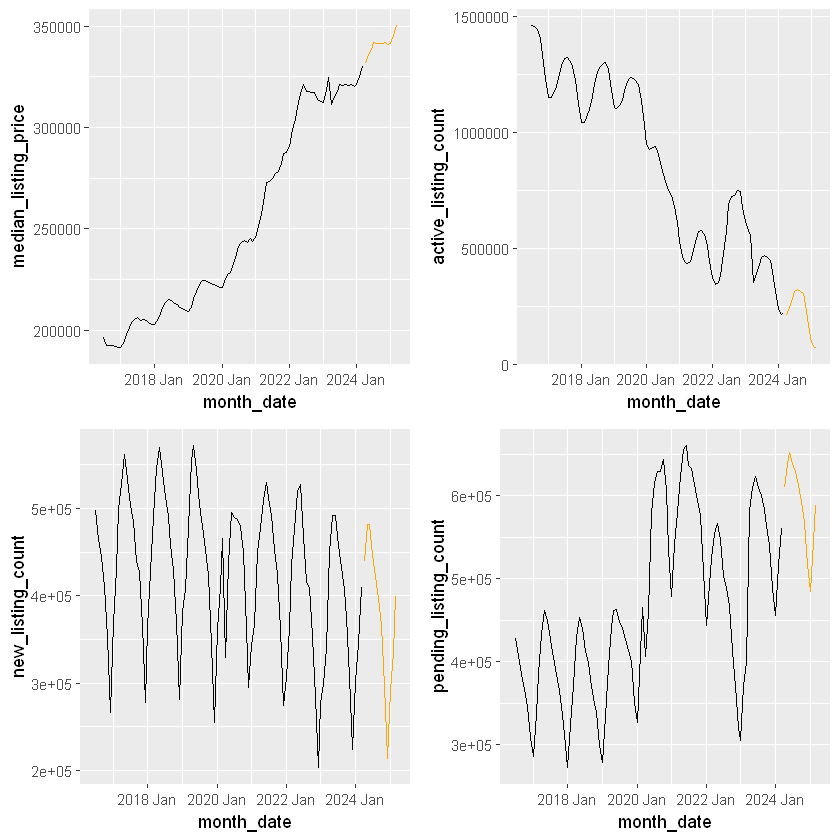

In [32]:

p1 <- ggplot(data = df_train, aes(x = month_date)) +
    geom_line(aes(y = median_listing_price))+
    geom_line(data = frcst_mlp %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
    geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Median Listing Price'),vjust = -1)


p2 <- ggplot(data = df_train, aes(x = month_date)) +
    geom_line(aes(y = active_listing_count))+
    geom_line(data = frcst_alc %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange') +
    geom_text(data = NULL,aes(x = Inf, y = Inf,label = 'Active Listing Count'),vjust = -1)


p3 <- ggplot(data = df_train, aes(x = month_date)) +
    geom_line(aes(y = new_listing_count))+
    geom_line(data = frcst_nlc %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange') +
    geom_text(data = NULL,aes(x = Inf, y = Inf,label = 'new Listing Count'),vjust = -1)

p4 <- ggplot(data = df_train, aes(x = month_date)) +
    geom_line(aes(y = pending_listing_count))+
    geom_line(data = frcst_plc %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange') +
    geom_text(data = NULL,aes(x = Inf, y = Inf,label = 'pending Listing Count'),vjust = -1)

grid.arrange(p1,p2,p3,p4,ncol = 2)

Verifying if we have any negative forecast. Used Logarithmic and sqrt transformations to avoid the negative forecat

In [33]:
frcst_mlp %>% filter(.model == 'stlm_st') %>% filter(.mean <= 0) %>% dim()
frcst_alc %>% filter(.model == 'stlm_st') %>% filter(.mean <= 0) %>% dim()
frcst_nlc %>% filter(.model == 'stlm_st') %>% filter(.mean <= 0) %>% dim()
frcst_plc %>% filter(.model == 'stlm_st') %>% filter(.mean <= 0) %>% dim()

[1] 0 4

[1] 0 4

[1] 0 4

[1] 0 4

Working on state aggregate

In [34]:
state_df <- read.csv('./data/state_wise_aggregate.csv')
state_df <- state_df %>% mutate(month_date = yearmonth(as.character(month_date),format = '%Y %m'))
state_df <- state_df %>% filter(state %in% c('md','va','pa','de','nj')) %>% select(state,month_date,active_listing_count)
state_df_ts <- state_df %>% as_tsibble(index=month_date, key = state)
state_df_ts %>% has_gaps() %>% filter(.gaps==TRUE) %>% dim()
state_df_ts %>% head()

[1] 0 2

state,month_date,active_listing_count
<chr>,<mth>,<dbl>
de,2016 Jul,7010
de,2016 Aug,6972
de,2016 Sep,6943
de,2016 Oct,6911
de,2016 Nov,6680
de,2016 Dec,6177


Splitting train vs test data (insample forecast - 2023 Apr to 2024 Mar)

[1] "Active Listing Count MD"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1447.915,1453.348,1479.043,0.09030789
stlm_t,1294.966,1295.278,1302.149,0.82377615
stlm_st,1289.179,1295.543,1322.701,0.87495075


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
md,stlm_s,2023 Apr,"N(14658, 5.8e+07)",14658.17
md,stlm_s,2023 May,"N(15667, 5.8e+07)",15666.83


[1] "Checking for negative forecast for md"


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>


[1] "Active Listing Count VA"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1531.455,1536.8873,1562.5823,0.08087724
stlm_t,1347.836,1348.1474,1355.0191,0.87807152
stlm_st,-256.940,-250.5764,-223.4177,0.88616142


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
va,stlm_s,2023 Apr,"N(24303, 1.6e+08)",24302.53
va,stlm_s,2023 May,"N(25755, 1.6e+08)",25754.84


[1] "Checking for negative forecast for va"


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>


[1] "Active Listing Count PA"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1570.277,1575.710,1601.405,0.07729799
stlm_t,1380.699,1381.011,1387.883,0.88627888
stlm_st,1366.361,1372.725,1399.884,0.92738788


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
pa,stlm_s,2023 Apr,"N(30525, 2.6e+08)",30525.50
pa,stlm_s,2023 May,"N(32198, 2.6e+08)",32198.17


[1] "Checking for negative forecast for pa"


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>


[1] "Active Listing Count DE"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1242.1778,1247.6107,1273.3057,0.02990764
stlm_t,-242.4915,-242.1798,-235.3081,0.85206912
stlm_st,-226.4110,-220.0474,-192.8887,0.86249444
stlm_st_sqrt,289.4848,295.8484,323.0071,0.89819870


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
de,stlm_s,2023 Apr,"N(3699, 4542710)",3699.167
de,stlm_s,2023 May,"N(3763, 4542710)",3763.000


[1] "Checking for negative forecast for de"


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>


[1] "Active Listing Count NJ"


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1555.015,1560.448,1586.143,0.08092254
stlm_t,1372.776,1373.088,1379.960,0.87598246
stlm_st,1360.906,1367.270,1394.428,0.91836399


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
nj,stlm_s,2023 Apr,"N(30852, 2.2e+08)",30852.17
nj,stlm_s,2023 May,"N(32563, 2.2e+08)",32563.33


[1] "Checking for negative forecast for nj"


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


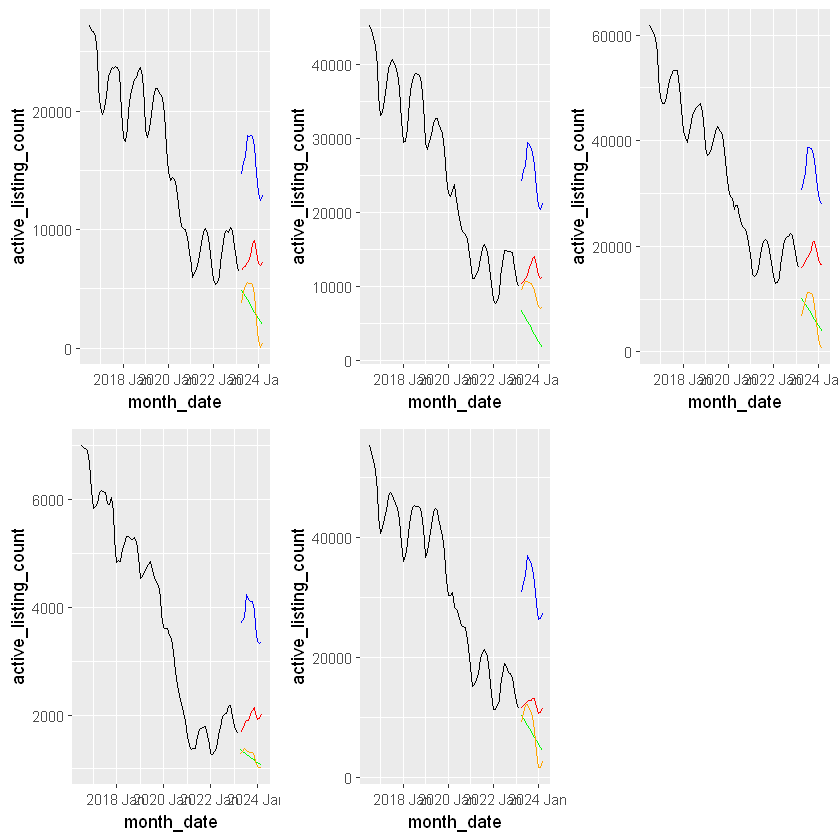

In [35]:

df_train <- state_df_ts %>% filter(month_date <= yearmonth(as.character('2023 Mar'), format = '%Y %m'))
df_test <- state_df_ts %>% filter(month_date > yearmonth(as.character('2023 Mar'), format = '%Y %m'))
fit_md <- df_train %>% filter(state == 'md') %>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(active_listing_count ~ trend()),
        stlm_st = TSLM(active_listing_count ~ season() + trend())
    )
print("Active Listing Count MD")
fit_md %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_md <- fit_md %>% forecast(h = 12)
frcst_md %>% head(2)
print('Checking for negative forecast for md')
frcst_md %>% filter(.mean <= 0) 

fit_va <- df_train  %>% filter(state == 'va')%>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(active_listing_count ~ trend()),
        stlm_st = TSLM(log(active_listing_count) ~ season() + trend())
    )
print("Active Listing Count VA")
fit_va %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_va <- fit_va %>% forecast(h = 12)
frcst_va %>% head(2)
print('Checking for negative forecast for va')
frcst_va %>% filter(.mean <= 0) 
fit_pa <- df_train %>% filter(state == 'pa') %>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(active_listing_count ~ trend()),
        stlm_st = TSLM(active_listing_count ~ season() + trend())
    )
print("Active Listing Count PA")
fit_pa %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_pa <- fit_pa %>% forecast(h = 12)
frcst_pa %>% head(2)
print('Checking for negative forecast for pa')
frcst_pa %>% filter(.mean <= 0) 

fit_de <- df_train %>% filter(state == 'de') %>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(log(active_listing_count) ~ trend()),
        stlm_st = TSLM(log(active_listing_count) ~ season() + trend()),
        stlm_st_sqrt = TSLM(sqrt(active_listing_count) ~ season() + trend())
    )
print("Active Listing Count DE")
fit_de %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_de <- fit_de %>% forecast(h = 12)
frcst_de %>% head(2)
print('Checking for negative forecast for de')
frcst_de %>% filter(.mean <= 0) 

fit_nj <- df_train %>% filter(state == 'nj') %>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(active_listing_count ~ trend()),
        stlm_st = TSLM(active_listing_count ~ season() + trend())
    )
print("Active Listing Count NJ")
fit_nj %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_nj <- fit_nj %>% forecast(h = 12)
frcst_nj %>% head(2)
print('Checking for negative forecast for nj')
frcst_nj %>% filter(.mean <= 0) 

p1 <- ggplot(data = df_train %>% filter(state == 'md'), aes(x = month_date)) +
        geom_line(aes(y = active_listing_count))+
        geom_line(data = df_test %>% filter(state == 'md'), aes(y = active_listing_count), color ='red') +
        geom_line(data = frcst_md %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
        geom_line(data = frcst_md %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
        geom_line(data = frcst_md %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
        geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count md'),vjust = -1)

p2 <- ggplot(data = df_train %>% filter(state == 'va'), aes(x = month_date)) +
        geom_line(aes(y = active_listing_count))+
        geom_line(data = df_test %>% filter(state == 'va'), aes(y = active_listing_count), color ='red') +
        geom_line(data = frcst_va %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
        geom_line(data = frcst_va %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
        geom_line(data = frcst_va %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
        geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count va'),vjust = -1)

p3 <- ggplot(data = df_train %>% filter(state == 'pa'), aes(x = month_date)) +
        geom_line(aes(y = active_listing_count))+
        geom_line(data = df_test %>% filter(state == 'pa'), aes(y = active_listing_count), color ='red') +
        geom_line(data = frcst_pa %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
        geom_line(data = frcst_pa %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
        geom_line(data = frcst_pa %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
        geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count pa'),vjust = -1)


p4 <- ggplot(data = df_train  %>% filter(state == 'de'), aes(x = month_date)) +
        geom_line(aes(y = active_listing_count))+
        geom_line(data = df_test %>% filter(state == 'de'), aes(y = active_listing_count), color ='red') +
        geom_line(data = frcst_de %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
        geom_line(data = frcst_de %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
        geom_line(data = frcst_de %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
        geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count de'),vjust = -1)

p5 <- ggplot(data = df_train %>% filter(state == 'nj'), aes(x = month_date)) +
        geom_line(aes(y = active_listing_count))+
        geom_line(data = df_test %>% filter(state == 'nj'), aes(y = active_listing_count), color ='red') +
        geom_line(data = frcst_nj %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
        geom_line(data = frcst_nj %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
        geom_line(data = frcst_nj %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
        geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count nj'),vjust = -1)
ggsave('./plots/md_if.png',p1)
ggsave('./plots/va_if.png',p2)
ggsave('./plots/pa_if.png',p3)
ggsave('./plots/de_if.png',p4)
ggsave('./plots/nj_if.png',p5)
grid.arrange(p1,p2,p3,p4,p5,ncol = 3)

**Performace Analysis for each of the model:**
- **MD**
    - **stlm_st:** This model seems to have the best overall performance:
        - Highest R-squared (0.87495): It explains the most variance in the data compared to other models.
        - Lowest AIC and BIC: Despite explaining the highest variance, its AIC (1289.179) and BIC (1322.701) are the lowest, suggesting a good balance between fit and complexity.
    - **stlm_t:** This model also performs well, with a high R-squared (0.82377). However, its AIC (1294.966) and BIC (1302.149) are slightly higher than stlm_st, indicating a slightly less parsimonious model.
    - **stlm_s:** This model is the least suitable, as it has the lowest R-squared (0.09030789) and the highest AIC (1447.915) and BIC (1479.043), indicating a poor fit and higher complexity.
- **VA**
    - **stlm_s:** This model seems to have the poorest performance with the highest AIC, AICc, BIC values and the lowest R-squared. This implies it has a relatively weak fit to the data and may be overfitting.
    - **stlm_t:** This model shows a substantial improvement over stlm_s. It has a much higher R-squared (0.878), indicating it explains a good portion of the variance in the data. Its AIC and BIC are also lower than stlm_s, suggesting a better balance between fit and complexity.
    - **stlm_st:** This model stands out as the most promising:
        - Highest R-squared (0.886): Indicates the best fit to the data. 
        - Lowest AIC and BIC: Despite fitting the data well, its complexity is still relatively low, reducing the risk of overfitting.
- **PA**
    - **stlm_st appears to be the best-performing model:** 
        - It has the highest R-squared value (0.92738788), indicating that it explains the most variance in the data compared to the other two models.
        - It also has the lowest AIC (1366.361) and BIC (1399.884) values, suggesting a good balance between model fit and complexity.
    - **stlm_t** also performs well, with a high R-squared value (0.88627888) and relatively low AIC (1380.699) and BIC (1387.883).
    - **stlm_s** is the least suitable model as it has the lowest R-squared (0.07729799) and highest AIC (1570.277) and BIC (1601.405) values, indicating a poor fit and higher complexity.
- **DE**
    - **stlm_st_sqrt appears to be the best-fitting model:**
        - It has the highest R-squared value (0.898), indicating it explains the largest proportion of variance in the data compared to the other three models.
        - However, it also has the highest AIC (289.48), AICc (295.85), and BIC (323.007) values, suggesting it might be slightly overfitting the data due to its increased complexity.
    - **stlm_t and stlm_st are strong contenders:**
        - Both have relatively high R-squared values (0.852 and 0.862 respectively), demonstrating good fits to the data.
        - Their AIC and BIC values are substantially lower than stlm_st_sqrt, indicating they are more parsimonious models.
    - **stlm_s is the least suitable model:**
        - It has the lowest R-squared value (0.0299), suggesting a poor fit to the data.
        - It also has the highest AIC (1242.178), AICc (1247.61), and BIC (1273.306) values, further indicating its lack of suitability.
- **NJ**
    - **stlm_s:** This model seems to have the poorest performance with the highest AIC, AICc, and BIC values and the lowest R-squared. This implies it has a relatively weak fit to the data and may be overfitting.
    - **stlm_t:** This model shows a substantial improvement over stlm_s. It has a much higher R-squared (0.875), indicating it explains a good portion of the variance in the data. Its AIC and BIC are also lower than stlm_s, suggesting a better balance between fit and complexity.
    - **stlm_st:** This model stands out as the most promising:
        - Highest R-squared (0.918): Indicates the best fit to the data.
        - Lowest AIC and BIC: Despite fitting the data well, its complexity is still relatively low, reducing the risk of overfitting.

    
    

In [36]:
df_test_md <- df_test %>% filter(state == 'md')
df_test_md$active_listing_count <- frcst_md %>%
    filter(.model == 'stlm_st') %>%
    mutate(active_listing_count_frcst = .mean) %>% as.data.frame() %>%
    select(active_listing_count_frcst) %>% unlist()

df_test_va <- df_test %>% filter(state == 'va')
df_test_va$active_listing_count <- frcst_va %>%
    filter(.model == 'stlm_st') %>%
    mutate(active_listing_count_frcst = .mean) %>% as.data.frame() %>%
    select(active_listing_count_frcst) %>% unlist()

df_test_pa <- df_test %>% filter(state == 'pa')
df_test_pa$active_listing_count <- frcst_pa %>%
    filter(.model == 'stlm_st') %>%
    mutate(active_listing_count_frcst = .mean) %>% as.data.frame() %>%
    select(active_listing_count_frcst) %>% unlist()

df_test_de <- df_test %>% filter(state == 'de')
df_test_de$active_listing_count <- frcst_de %>%
    filter(.model == 'stlm_st_sqrt') %>%
    mutate(active_listing_count_frcst = .mean) %>% as.data.frame() %>%
    select(active_listing_count_frcst) %>% unlist()

df_test_nj <- df_test %>% filter(state == 'nj')
df_test_nj$active_listing_count <- frcst_nj %>%
    filter(.model == 'stlm_st') %>%
    mutate(active_listing_count_frcst = .mean) %>% as.data.frame() %>%
    select(active_listing_count_frcst) %>% unlist()

combined_df <- bind_rows(df_train,df_test_md)
combined_df <- bind_rows(df_test_va,combined_df)
combined_df <- bind_rows(df_test_pa,combined_df)
combined_df <- bind_rows(df_test_de,combined_df)
combined_df <- bind_rows(df_test_nj,combined_df)

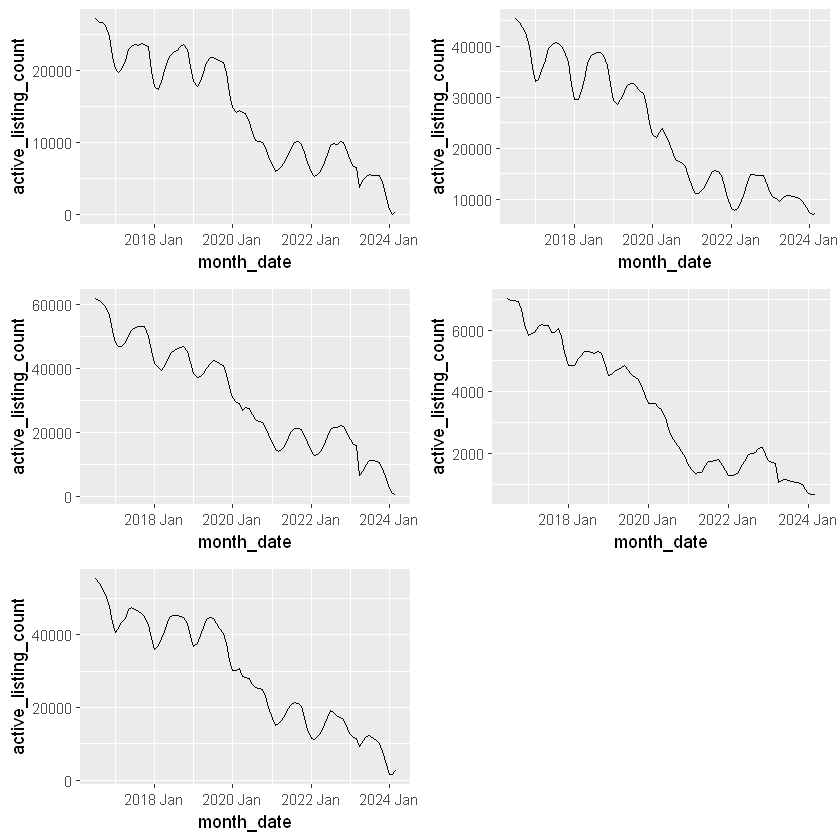

In [37]:
p1 <- ggplot(data = combined_df %>% as.data.frame()%>% filter(state =='md'),aes(x = month_date,y = active_listing_count))+
geom_line()

p2 <- ggplot(data = combined_df %>% as.data.frame()%>% filter(state =='va'),aes(x = month_date,y = active_listing_count))+
geom_line()

p3 <- ggplot(data = combined_df %>% as.data.frame()%>% filter(state =='pa'),aes(x = month_date,y = active_listing_count))+
geom_line()

p4 <- ggplot(data = combined_df %>% as.data.frame()%>% filter(state =='de'),aes(x = month_date,y = active_listing_count))+
geom_line()

p5 <- ggplot(data = combined_df %>% as.data.frame()%>% filter(state =='nj'),aes(x = month_date,y = active_listing_count))+
geom_line()

grid.arrange(p1,p2,p3,p4,p5,ncol = 2)

.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1680.02892,1684.63652,1712.9527,0.07277805
stlm_t,1476.94161,1477.21127,1484.5394,0.87052185
stlm_st,-58.34169,-52.95707,-22.8853,0.60934327


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
md,stlm_s,2024 Apr,"N(13105, 7e+07)",13104.99
md,stlm_s,2024 May,"N(14114, 7e+07)",14113.66


[1] "Checking for negative forecast for md"


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
md,stlm_t,2024 Nov,"N(-55, 8e+06)",-54.93081
md,stlm_t,2024 Dec,"N(-318, 8e+06)",-317.62490
md,stlm_t,2025 Jan,"N(-580, 8e+06)",-580.31900
md,stlm_t,2025 Feb,"N(-843, 8e+06)",-843.01309
md,stlm_t,2025 Mar,"N(-1106, 8e+06)",-1105.70719


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1765.0064,1769.6140,1797.9302,0.06271288
stlm_t,1546.5592,1546.8289,1554.1570,0.88904231
stlm_st,-311.8842,-306.4996,-276.4278,0.91908074
stlm_st_sqrt,470.2794,475.6641,505.7358,0.92731325


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
va,stlm_s,2024 Apr,"N(22200, 1.7e+08)",22199.79
va,stlm_s,2024 May,"N(23544, 1.7e+08)",23544.19


[1] "Checking for negative forecast for va"


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
va,stlm_t,2025 Jan,"N(-49, 1.7e+07)",-48.74629
va,stlm_t,2025 Feb,"N(-466, 1.7e+07)",-465.70449
va,stlm_t,2025 Mar,"N(-883, 1.7e+07)",-882.66269


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1822.4533,1827.0609,1855.3771,0.06097065
stlm_t,1576.3645,1576.6342,1583.9623,0.91741864
stlm_st,-148.1627,-142.7781,-112.7063,0.76173787
stlm_st_sqrt,518.9427,524.3273,554.3991,0.92443664


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
pa,stlm_s,2024 Apr,"N(27109, 3.2e+08)",27109.12
pa,stlm_s,2024 May,"N(28782, 3.2e+08)",28781.79


[1] "Checking for negative forecast for pa"


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
pa,stlm_t,2024 Oct,"N(-93, 2.3e+07)",-92.59468
pa,stlm_t,2024 Nov,"N(-669, 2.3e+07)",-668.89068
pa,stlm_t,2024 Dec,"N(-1245, 2.3e+07)",-1245.18668
pa,stlm_t,2025 Jan,"N(-1821, 2.3e+07)",-1821.48268
pa,stlm_t,2025 Feb,"N(-2398, 2.3e+07)",-2397.77868
pa,stlm_t,2025 Mar,"N(-2974, 2.3e+07)",-2974.07468


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1434.9090,1439.5166,1467.8328,0.02305849
stlm_t,-279.3045,-279.0348,-271.7067,0.89782062
stlm_st,-265.7171,-260.3325,-230.2607,0.90665793
stlm_st_sqrt,315.4884,320.8731,350.9448,0.92898392


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
de,stlm_s,2024 Apr,"N(3324, 5e+06)",3323.563
de,stlm_s,2024 May,"N(3384, 5e+06)",3384.255


[1] "Checking for negative forecast for de"


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>


.model,AIC,AICc,BIC,r_squared
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stlm_s,1804.5994,1809.2070,1837.5232,0.06404659
stlm_t,1566.9614,1567.2310,1574.5591,0.90985935
stlm_st,-194.0890,-188.7044,-158.6326,0.82398658
stlm_st_sqrt,503.2739,508.6585,538.7303,0.92767183


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
nj,stlm_s,2024 Apr,"N(27760, 2.7e+08)",27760.09
nj,stlm_s,2024 May,"N(29471, 2.7e+08)",29471.26


[1] "Checking for negative forecast for nj"


state,.model,month_date,active_listing_count,.mean
<chr>,<chr>,<mth>,<dist>,<dbl>
nj,stlm_t,2025 Jan,"N(-457, 2.1e+07)",-457.0039
nj,stlm_t,2025 Feb,"N(-979, 2.1e+07)",-979.2487
nj,stlm_t,2025 Mar,"N(-1501, 2.1e+07)",-1501.4935


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


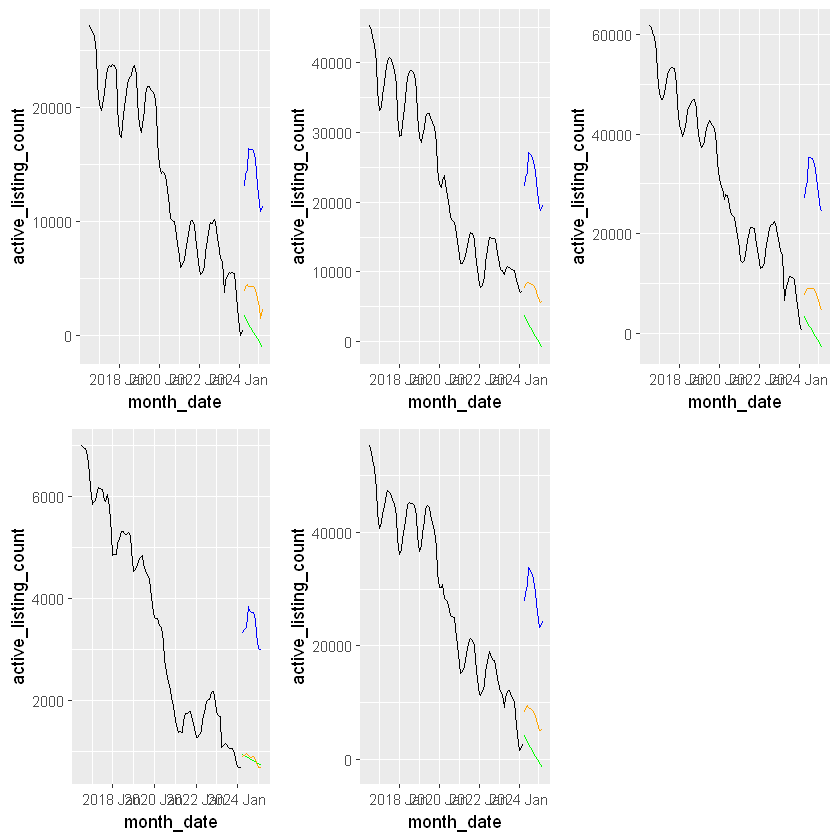

In [38]:
df_train <- combined_df

fit_md <- df_train %>% filter(state == 'md') %>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(active_listing_count ~ trend()),
        stlm_st = TSLM(log(active_listing_count) ~ season() + trend())
    )

fit_md %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_md <- fit_md %>% forecast(h = 12)
frcst_md %>% head(2)
print('Checking for negative forecast for md')
frcst_md %>% filter(.mean <= 0) 

fit_va <- df_train  %>% filter(state == 'va')%>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(active_listing_count ~ trend()),
        stlm_st = TSLM(log(active_listing_count) ~ season() + trend()),
        stlm_st_sqrt = TSLM(sqrt(active_listing_count) ~ season() + trend())
    )

fit_va %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_va <- fit_va %>% forecast(h = 12)
frcst_va %>% head(2)
print('Checking for negative forecast for va')
frcst_va %>% filter(.mean <= 0) 
fit_pa <- df_train %>% filter(state == 'pa') %>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(active_listing_count ~ trend()),
        stlm_st = TSLM(log(active_listing_count) ~ season() + trend()),
        stlm_st_sqrt = TSLM(sqrt(active_listing_count) ~ season() + trend())
    )

fit_pa %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_pa <- fit_pa %>% forecast(h = 12)
frcst_pa %>% head(2)
print('Checking for negative forecast for pa')
frcst_pa %>% filter(.mean <= 0) 

fit_de <- df_train %>% filter(state == 'de') %>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(log(active_listing_count) ~ trend()),
        stlm_st = TSLM(log(active_listing_count) ~ season() + trend()),
        stlm_st_sqrt = TSLM(sqrt(active_listing_count) ~ season() + trend())
    )

fit_de %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_de <- fit_de %>% forecast(h = 12)
frcst_de %>% head(2)
print('Checking for negative forecast for de')
frcst_de %>% filter(.mean <= 0) 

fit_nj <- df_train %>% filter(state == 'nj') %>% 
    model(
        stlm_s = TSLM(active_listing_count ~ season()),
        stlm_t = TSLM(active_listing_count ~ trend()),
        stlm_st = TSLM(log(active_listing_count) ~ season() + trend()),
        stlm_st_sqrt = TSLM(sqrt(active_listing_count) ~ season() + trend())
    )

fit_nj %>% report() %>%
    select(.model, AIC, AICc, BIC, r_squared)
frcst_nj <- fit_nj %>% forecast(h = 12)
frcst_nj %>% head(2)
print('Checking for negative forecast for nj')
frcst_nj %>% filter(.mean <= 0) 

p1 <- ggplot(data = df_train %>% filter(state == 'md'), aes(x = month_date)) +
        geom_line(aes(y = active_listing_count))+
        geom_line(data = frcst_md %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
        geom_line(data = frcst_md %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
        geom_line(data = frcst_md %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
        geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count md'),vjust = -1)

p2 <- ggplot(data = df_train %>% filter(state == 'va'), aes(x = month_date)) +
        geom_line(aes(y = active_listing_count))+
        geom_line(data = frcst_va %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
        geom_line(data = frcst_va %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
        geom_line(data = frcst_va %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
        geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count va'),vjust = -1)

p3 <- ggplot(data = df_train %>% filter(state == 'pa'), aes(x = month_date)) +
        geom_line(aes(y = active_listing_count))+
        geom_line(data = frcst_pa %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
        geom_line(data = frcst_pa %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
        geom_line(data = frcst_pa %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
        geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count pa'),vjust = -1)


p4 <- ggplot(data = df_train  %>% filter(state == 'de'), aes(x = month_date)) +
        geom_line(aes(y = active_listing_count))+
        geom_line(data = frcst_de %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
        geom_line(data = frcst_de %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
        geom_line(data = frcst_de %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
        geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count de'),vjust = -1)

p5 <- ggplot(data = df_train %>% filter(state == 'nj'), aes(x = month_date)) +
        geom_line(aes(y = active_listing_count))+
        geom_line(data = frcst_nj %>% filter(.model == 'stlm_s'), aes(y = .mean),color = 'blue') +
        geom_line(data = frcst_nj %>% filter(.model == 'stlm_t'), aes(y = .mean),color = 'green') +
        geom_line(data = frcst_nj %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
        geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count nj'),vjust = -1)

grid.arrange(p1,p2,p3,p4,p5,ncol = 3)

ggsave('./plots/md_of.png',p1)
ggsave('./plots/va_of.png',p2)
ggsave('./plots/pa_of.png',p3)
ggsave('./plots/de_of.png',p4)
ggsave('./plots/nj_of.png',p5)

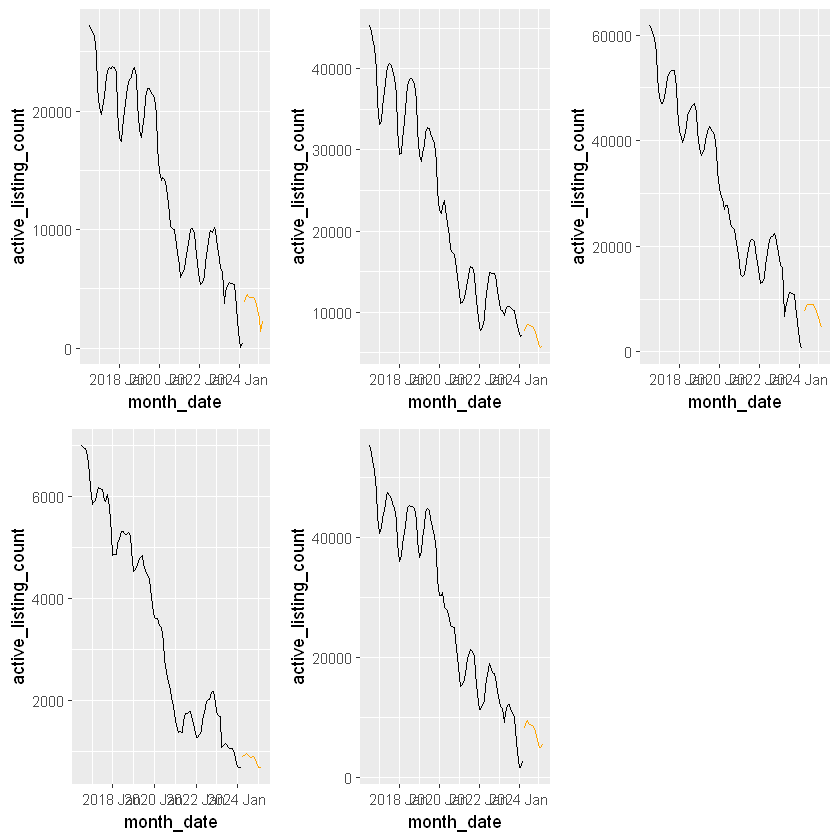

In [39]:
p1 <- ggplot(data = df_train %>% filter(state == 'md'), aes(x = month_date)) +
    geom_line(aes(y = active_listing_count))+
    geom_line(data = frcst_md %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
    geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count MD'),vjust = -1)

p2 <- ggplot(data = df_train  %>% filter(state == 'va'), aes(x = month_date)) +
    geom_line(aes(y = active_listing_count))+
    geom_line(data = frcst_va %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
    geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count VA'),vjust = -1)

p3 <- ggplot(data = df_train  %>% filter(state == 'pa'), aes(x = month_date)) +
    geom_line(aes(y = active_listing_count))+
    geom_line(data = frcst_pa %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
    geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count PA'),vjust = -1)

p4 <- ggplot(data = df_train  %>% filter(state == 'de'), aes(x = month_date)) +
    geom_line(aes(y = active_listing_count))+
    geom_line(data = frcst_de %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
    geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count DE'),vjust = -1)

p5 <- ggplot(data = df_train  %>% filter(state == 'nj'), aes(x = month_date)) +
    geom_line(aes(y = active_listing_count))+
    geom_line(data = frcst_nj %>% filter(.model == 'stlm_st'), aes(y = .mean),color = 'orange')+
    geom_text(data = NULL,aes(x = Inf, y = Inf, label = 'Active Listing Count NJ'),vjust = -1)
grid.arrange(p1,p2,p3,p4,p5,ncol=3)